In [163]:
import pyxdf
import mne
from mne.decoding import CSP
from mne.preprocessing import EOGRegression
from mne.stats import permutation_cluster_1samp_test as pcluster_test
import scipy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import TwoSlopeNorm
from sklearn.svm import SVC 
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score,classification_report
from sklearn.model_selection import train_test_split

from mnetools import streams2mnedata, preprocessing

In [164]:
# -- |Data details| --
participant_id = 0
session = 4
# -- |Data Selection| --
initial_run = 1
n_run = 5

# -- |Parameters| --
tmin= -0.5
tmax= 3

# -- |Event dictionary| --
# Set up your event name
if session == 1 : events_id = {'right': 0, 'left': 1}
else            : events_id = {'none': 0, 'right': 1, 'left': 2}

# **Raw Data Overview**

In [165]:
# -- |Local parameters|--
epochs_list = [] 

for i in range(initial_run,initial_run+n_run):
    # -- |File import| --
    streams, header = pyxdf.load_xdf(f"Data/sub-P{participant_id:003d}/ses-S{session:003d}/eeg/sub-P{participant_id:003d}_ses-S{session:003d}_task-Default_run-{i:003d}_eeg.xdf") #Example Data from Lab Recoder

    raw_mne, events = streams2mnedata(streams)
    epochs = mne.Epochs(raw_mne, events, tmin= -0.5,  tmax= 3, event_id = events_id, preload = True,verbose=False,picks = ['C3','Cz','C4','PO7','Pz','PO8','EOG'])

    epochs_list.append(epochs)

epochs = mne.concatenate_epochs(epochs_list)
epochs.set_montage(mne.channels.make_standard_montage('standard_1020'))

Number of events,230
Events,left: 75none: 80right: 75
Time range,-0.500 – 3.000 s
Baseline,-0.500 – 0.000 s


In [166]:
raw_mne.get_data()[:,:10]

array([[-0.01768808, -0.01762527, -0.01749717, -0.01752377, -0.01761087,
        -0.01768032, -0.01762341, -0.01749833, -0.01751534, -0.01759275],
       [-0.00150608, -0.00145161, -0.00133762, -0.00136332, -0.00143784,
        -0.00150061, -0.00145409, -0.00134432, -0.00136214, -0.00142736],
       [ 0.01141238,  0.01138381,  0.01139143,  0.01138046,  0.01142909,
         0.01141881,  0.01138622,  0.0113898 ,  0.01138421,  0.01144146],
       [-0.00968257, -0.00962687, -0.00951158, -0.00953304, -0.00961708,
        -0.00968112, -0.00962828, -0.00951404, -0.0095292 , -0.00960553],
       [-0.00532025, -0.00525744, -0.00512718, -0.00514975, -0.00524417,
        -0.00531824, -0.00526086, -0.00513366, -0.00514794, -0.00523397],
       [ 0.00064319,  0.000694  ,  0.00080683,  0.00078164,  0.00070374,
         0.0006419 ,  0.00068875,  0.00079507,  0.00077663,  0.00070991],
       [-0.00074655, -0.00068989, -0.00057203, -0.00059608, -0.00068003,
        -0.00074579, -0.00069192, -0.00057748

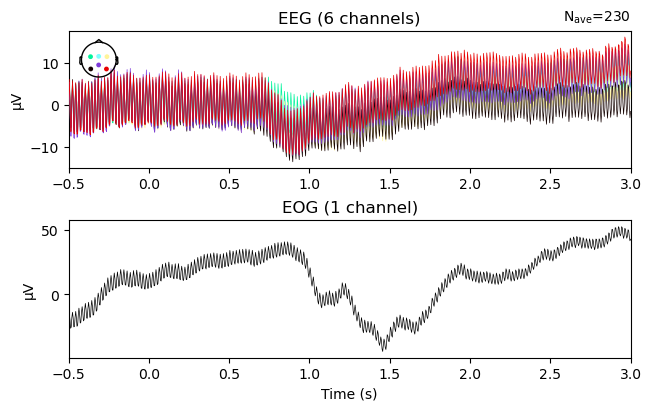

In [167]:
plot_kwargs = dict(picks="all")

# plot the evoked for the EEG and the EOG sensors
fig = epochs.average("all").plot(**plot_kwargs)
fig.set_size_inches(6, 6)

C:\Users\AbsoluteZeno\AppData\Local\Temp\ipykernel_45656\3855270505.py:1: FutureWarning: The value of `amplitude='auto'` will be removed in MNE 1.8.0, and the new default will be `amplitude=False`.
  epochs.compute_psd(fmin=0,fmax=50).plot()
c:\Users\AbsoluteZeno\anaconda3\Lib\site-packages\mne\viz\utils.py:167: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


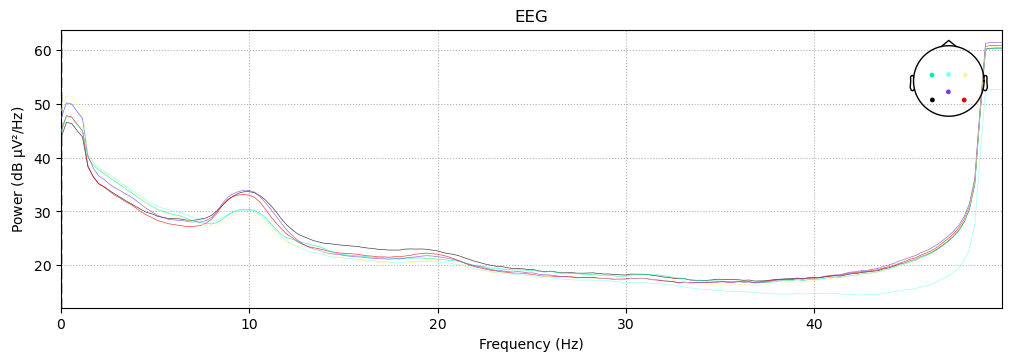

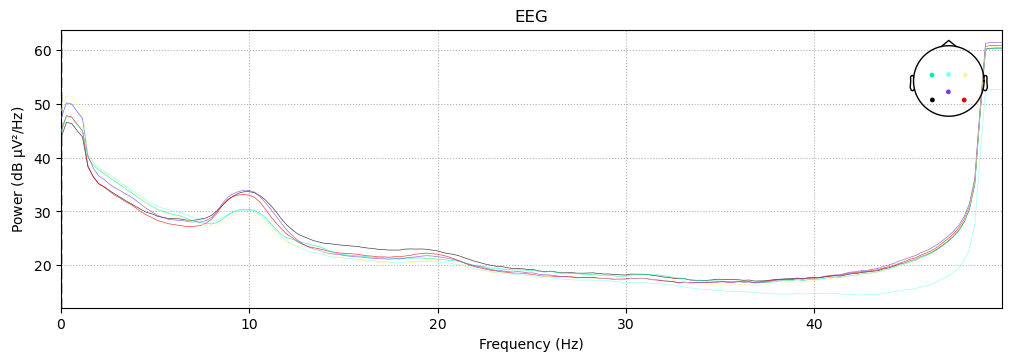

In [168]:
epochs.compute_psd(fmin=0,fmax=50).plot()

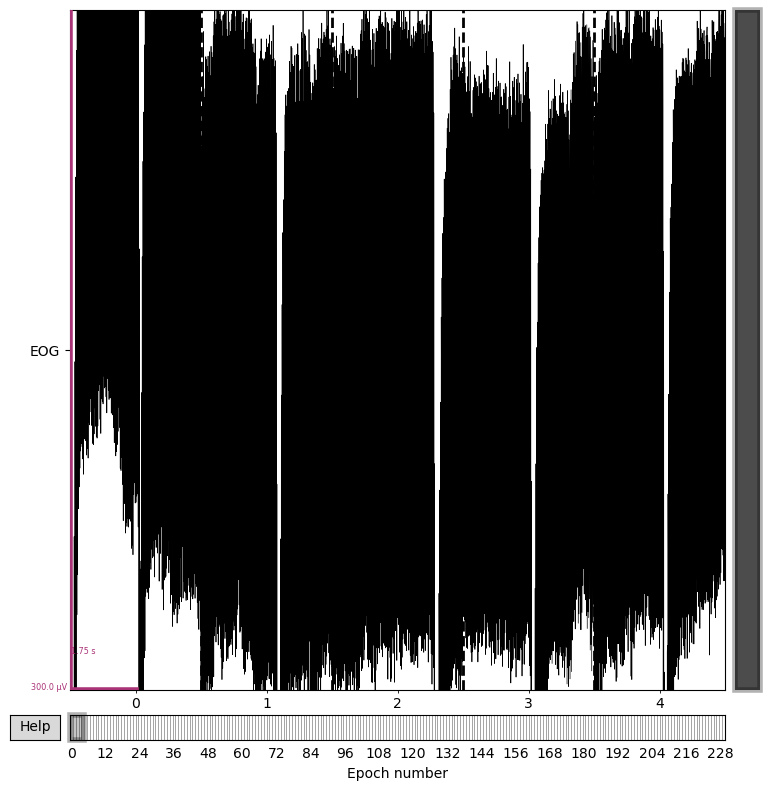

In [169]:
epochs.plot(picks='EOG', n_epochs=5);

# **Processing**

In [170]:
# -- |Local parameters|--
epochs_list = [] 

for i in range(initial_run,initial_run+n_run):
    # -- |File import| --
    streams, header = pyxdf.load_xdf(f"Data/sub-P{participant_id:003d}/ses-S{session:003d}/eeg/sub-P{participant_id:003d}_ses-S{session:003d}_task-Default_run-{i:003d}_eeg.xdf") #Example Data from Lab Recoder

    raw_mne, events = streams2mnedata(streams)
    prepro_mne = preprocessing(raw_mne)
    
    # -- |Epoch Segmentation| --
    epochs = mne.Epochs(prepro_mne, events, tmin= tmin,  tmax= tmax, event_id = events_id, preload = True,verbose=False,picks = ['C3','Cz','C4','PO7','Pz','PO8','EOG'])

    epochs_list.append(epochs)

epochs = mne.concatenate_epochs(epochs_list)
epochs.set_montage(mne.channels.make_standard_montage('standard_1020'))

Number of events,230
Events,left: 75none: 80right: 75
Time range,-0.500 – 3.000 s
Baseline,-0.500 – 0.000 s


## Part 1: Without artifact removal

### 1.1 Left vs. Right Classification

#### 1.1.1 SVM

Train set shape: (120, 7)
Test set shape : (30, 7)


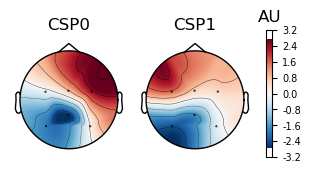

Accuracy: 0.7666666666666667
              precision    recall  f1-score   support

       right       0.83      0.67      0.74        15
        left       0.72      0.87      0.79        15

    accuracy                           0.77        30
   macro avg       0.78      0.77      0.76        30
weighted avg       0.78      0.77      0.76        30



In [171]:
mne.set_log_level(verbose=False)

# Get EEG data and events
X = epochs[['right','left']].get_data(copy=False)
Y = epochs[['right','left']].events[:, -1]

csp_list = []
svm_list = []
acc_list = []
report_list = []

for i in range(2, len(epochs.ch_names) + 1):
    # -- |Features Extraction| --
    # Initilize CSP
    csp = CSP(n_components = i, norm_trace = False)

    # Fit CSP to data 
    csp.fit(X,Y)
    csp_list.append(csp)

    # Transform data into CSP space
    X_transformed = csp.transform(X)

    # -- |Classification| --
    # Split data into training and test sets
    X_train, X_test, Y_train, Y_test = train_test_split(X_transformed, Y, test_size = 0.2, random_state = 42, stratify=Y)

    # Classification 
    svm = Pipeline([('SVM', SVC(kernel='linear'))])  
    svm.fit(X_train, Y_train)
    svm_list.append(svm)

    y_pred = svm.predict(X_test)
    accuracy = accuracy_score(Y_test, y_pred)
    acc_list.append(accuracy)

    report = classification_report(Y_test, y_pred, target_names=['right', 'left'])  # adjust target names accordingly
    report_list.append(report)

# -- |Select CSP which gives maximum accuracy| --
ind = np.argmax(acc_list) 

# -- |Print Data Shape| --
print(f'Train set shape: {X_train.shape}')
print(f'Test set shape : {X_test.shape}')

# -- |Visualize CSP patterns| --
csp = csp_list[ind]
csp.plot_patterns(epochs.info);

# -- |Classification results| --
svm = svm_list[ind]
print(f"Accuracy: {acc_list[ind]}")
print(report_list[ind])

#### 1.1.2 Logistic Regression

Train set shape: (120, 7)
Test set shape : (30, 7)


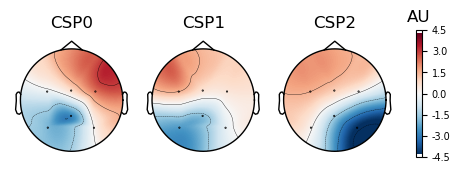

Accuracy: 0.7666666666666667
              precision    recall  f1-score   support

  none-right       0.83      0.67      0.74        15
       right       0.72      0.87      0.79        15

    accuracy                           0.77        30
   macro avg       0.78      0.77      0.76        30
weighted avg       0.78      0.77      0.76        30



In [172]:
csp_list = []
lr_list = []
acc_list = []
report_list = []

for i in range(2, len(epochs.ch_names) + 1):
    # -- |Features Extraction| --
    # Initilize CSP
    csp = CSP(n_components = i, norm_trace = False)

    # Fit CSP to data 
    csp.fit(X,Y)
    csp_list.append(csp)

    # Transform data into CSP space
    X_transformed = csp.transform(X)

    # -- |Classification| --
    # Split data into training and test sets
    X_train, X_test, Y_train, Y_test = train_test_split(X_transformed, Y, test_size = 0.2, random_state = 42, stratify=Y)

    # Classification 
    lr = Pipeline([('LR', LogisticRegression())])
    lr.fit(X_train, Y_train)
    lr_list.append(lr)

    y_pred = lr.predict(X_test)
    accuracy = accuracy_score(Y_test, y_pred)
    acc_list.append(accuracy)

    report = classification_report(Y_test, y_pred, target_names=['none-right', 'right'])  # adjust target names accordingly
    report_list.append(report)

# -- |Select CSP which gives maximum accuracy| --
ind = np.argmax(acc_list) 

# -- |Print Data Shape| --
print(f'Train set shape: {X_train.shape}')
print(f'Test set shape : {X_test.shape}')

# -- |Visualize CSP patterns| --
csp = csp_list[ind]
csp.plot_patterns(epochs.info);

# -- |Classification results| --
lr = lr_list[ind]
print(f"Accuracy: {acc_list[ind]}")
print(report_list[ind])

In [173]:
timewindow = np.full((7,500),1e-15)
channels = ['C3','Cz','C4','Pz','PO7','PO8','EOG'] # Set your target EEG channel name
info = mne.create_info(
    ch_names= channels,
    ch_types= ['eeg']*(len(channels) - 1) + ['eog'],
    sfreq= 250,  # OpenBCI Frequency acquistion
    verbose=False
)

In [174]:
sample = [np.random.rand(), np.random.rand(), np.random.rand(), np.random.rand(), np.random.rand(), np.random.rand(), np.random.rand(), np.random.rand()]
timewindow = np.concatenate([timewindow[:,1:], (np.array([sample[1:]])/1000000).T], axis=1)
timewindow_mne = mne.io.RawArray(timewindow, info, verbose=False)
timewindow_mne = preprocessing(timewindow_mne)

realtime_data = timewindow_mne.get_data()[:,-int((tmax-tmin)*250):]
realtime_data = realtime_data - np.array([np.mean(realtime_data[:int((0-tmin)*250)], axis = 1)]).T
realtime_data

array([[-4.39806077e-10, -4.39806077e-10, -4.39806077e-10, ...,
         2.94370500e-08,  1.50935875e-08, -4.39806077e-10],
       [-8.05613759e-10, -8.05613759e-10, -8.05613759e-10, ...,
         5.39212479e-08,  2.76476439e-08, -8.05613759e-10],
       [ 1.46066375e-10,  1.46066375e-10,  1.46066375e-10, ...,
        -9.77649786e-09, -5.01281298e-09,  1.46066375e-10],
       ...,
       [ 1.20482151e-09,  1.20482151e-09,  1.20482151e-09, ...,
        -8.06409751e-08, -4.13479481e-08,  1.20482151e-09],
       [-7.95689141e-10, -7.95689141e-10, -7.95689141e-10, ...,
         5.32569745e-08,  2.73070436e-08, -7.95689141e-10],
       [ 1.34744875e-09,  1.34744875e-09,  1.34744875e-09, ...,
        -9.01872856e-08, -4.62427345e-08,  1.34744875e-09]])

In [175]:
a = np.random.rand(5,6)
print(a,np.mean(a, axis = 1),a - np.array([np.mean(a, axis = 1)]).T)

[[0.46667156 0.68760638 0.58882057 0.99993698 0.72520712 0.78388974]
 [0.97939985 0.63993948 0.42605356 0.48320729 0.50914922 0.10475892]
 [0.50989249 0.70442767 0.21816674 0.98255655 0.53961609 0.60988335]
 [0.63384025 0.30538563 0.35221906 0.86023978 0.00875329 0.767424  ]
 [0.35006221 0.57773286 0.68522243 0.09318818 0.83910784 0.72384371]] [0.70868872 0.52375139 0.59409048 0.487977   0.54485954] [[-0.24201716 -0.02108234 -0.11986816  0.29124825  0.01651839  0.07520101]
 [ 0.45564847  0.11618809 -0.09769782 -0.0405441  -0.01460216 -0.41899247]
 [-0.08419799  0.11033719 -0.37592374  0.38846606 -0.05447439  0.01579287]
 [ 0.14586325 -0.18259137 -0.13575795  0.37226278 -0.47922371  0.279447  ]
 [-0.19479733  0.03287332  0.14036289 -0.45167136  0.2942483   0.17898417]]


### 1.2 Left vs. Non-left Classification

#### 1.2.1 SVM

c:\Users\AbsoluteZeno\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\AbsoluteZeno\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\AbsoluteZeno\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train set shape: (184, 7)
Test set shape : (46, 7)


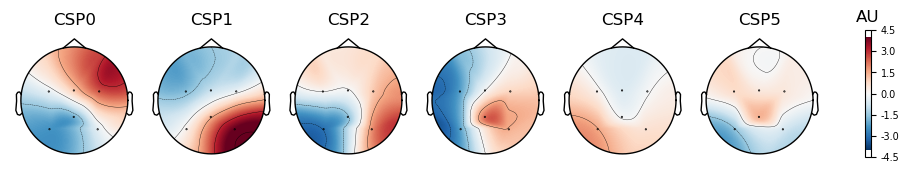

Accuracy: 0.7608695652173914
              precision    recall  f1-score   support

   none-left       0.78      0.90      0.84        31
        left       0.70      0.47      0.56        15

    accuracy                           0.76        46
   macro avg       0.74      0.68      0.70        46
weighted avg       0.75      0.76      0.75        46



In [176]:
epochs_l = epochs.copy()
epochs_l.events = mne.merge_events(epochs_l.events, [0, 1], 0, replace_events=True)
epochs_l.event_id = {'none-left': 0, 'left': 2}

# Get EEG data and events
X = epochs_l.get_data(copy=False)
Y = epochs_l.events[:, -1]

csp_list = []
svm_list = []
acc_list = []
report_list = []

for i in range(2, len(epochs.ch_names) + 1):
    # -- |Features Extraction| --
    # Initilize CSP
    csp = CSP(n_components = i, norm_trace = False)

    # Fit CSP to data 
    csp.fit(X,Y)
    csp_list.append(csp)

    # Transform data into CSP space
    X_transformed = csp.transform(X)

    # -- |Classification| --
    # Split data into training and test sets
    X_train, X_test, Y_train, Y_test = train_test_split(X_transformed, Y, test_size = 0.2, random_state = 42, stratify=Y)

    # Classification 
    svm = Pipeline([('SVM', SVC(kernel='linear'))])  
    svm.fit(X_train, Y_train)
    svm_list.append(svm)

    y_pred = svm.predict(X_test)
    accuracy = accuracy_score(Y_test, y_pred)
    acc_list.append(accuracy)

    report = classification_report(Y_test, y_pred, target_names=['none-left', 'left'])  # adjust target names accordingly
    report_list.append(report)

# -- |Select CSP which gives maximum accuracy| --
ind = np.argmax(acc_list) 

# -- |Print Data Shape| --
print(f'Train set shape: {X_train.shape}')
print(f'Test set shape : {X_test.shape}')

# -- |Visualize CSP patterns| --
csp = csp_list[ind]
csp.plot_patterns(epochs.info);

# -- |Classification results| --
svm = svm_list[ind]
print(f"Accuracy: {acc_list[ind]}")
print(report_list[ind])

#### 1.2.2 Logistic Regression

Train set shape: (184, 7)
Test set shape : (46, 7)


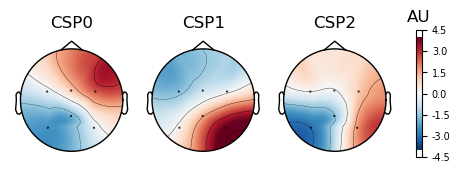

Accuracy: 0.7391304347826086
              precision    recall  f1-score   support

  none-right       0.74      0.94      0.83        31
       right       0.71      0.33      0.45        15

    accuracy                           0.74        46
   macro avg       0.73      0.63      0.64        46
weighted avg       0.73      0.74      0.71        46



In [177]:
csp_list = []
lr_list = []
acc_list = []
report_list = []

for i in range(2, len(epochs.ch_names) + 1):
    # -- |Features Extraction| --
    # Initilize CSP
    csp = CSP(n_components = i, norm_trace = False)

    # Fit CSP to data 
    csp.fit(X,Y)
    csp_list.append(csp)

    # Transform data into CSP space
    X_transformed = csp.transform(X)

    # -- |Classification| --
    # Split data into training and test sets
    X_train, X_test, Y_train, Y_test = train_test_split(X_transformed, Y, test_size = 0.2, random_state = 42, stratify=Y)

    # Classification 
    lr = Pipeline([('LR', LogisticRegression())])
    lr.fit(X_train, Y_train)
    lr_list.append(lr)

    y_pred = lr.predict(X_test)
    accuracy = accuracy_score(Y_test, y_pred)
    acc_list.append(accuracy)

    report = classification_report(Y_test, y_pred, target_names=['none-right', 'right'])  # adjust target names accordingly
    report_list.append(report)

# -- |Select CSP which gives maximum accuracy| --
ind = np.argmax(acc_list) 

# -- |Print Data Shape| --
print(f'Train set shape: {X_train.shape}')
print(f'Test set shape : {X_test.shape}')

# -- |Visualize CSP patterns| --
csp = csp_list[ind]
csp.plot_patterns(epochs.info);

# -- |Classification results| --
lr = lr_list[ind]
print(f"Accuracy: {acc_list[ind]}")
print(report_list[ind])

### 1.3 Right vs. Non-Right Classification

#### 1.3.1 SVM

Train set shape: (184, 7)
Test set shape : (46, 7)


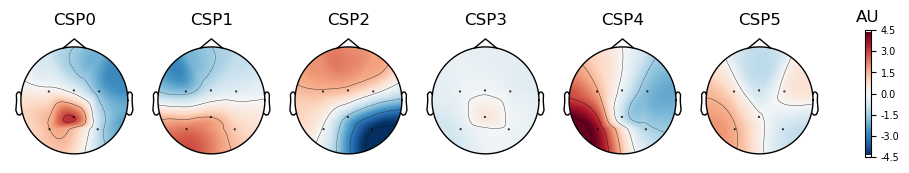

Accuracy: 0.8913043478260869
              precision    recall  f1-score   support

  none-right       0.93      0.90      0.92        31
       right       0.81      0.87      0.84        15

    accuracy                           0.89        46
   macro avg       0.87      0.88      0.88        46
weighted avg       0.89      0.89      0.89        46



In [178]:
epochs_r = epochs.copy()
epochs_r.events = mne.merge_events(epochs_r.events, [0, 2], 0, replace_events=True)
epochs_r.event_id = {'none-right': 0, 'right': 1}

# Get EEG data and events
X = epochs_r.get_data(copy=False)
Y = epochs_r.events[:, -1]

csp_list = []
svm_list = []
acc_list = []
report_list = []

for i in range(2, len(epochs.ch_names) + 1):
    # -- |Features Extraction| --
    # Initilize CSP
    csp = CSP(n_components = i, norm_trace = False)

    # Fit CSP to data 
    csp.fit(X,Y)
    csp_list.append(csp)

    # Transform data into CSP space
    X_transformed = csp.transform(X)

    # -- |Classification| --
    # Split data into training and test sets
    X_train, X_test, Y_train, Y_test = train_test_split(X_transformed, Y, test_size = 0.2, random_state = 42, stratify=Y)

    # Classification 
    svm = Pipeline([('SVM', SVC(kernel='linear'))])  
    svm.fit(X_train, Y_train)
    svm_list.append(svm)

    y_pred = svm.predict(X_test)
    accuracy = accuracy_score(Y_test, y_pred)
    acc_list.append(accuracy)

    report = classification_report(Y_test, y_pred, target_names=['none-right', 'right'])  # adjust target names accordingly
    report_list.append(report)

# -- |Select CSP which gives maximum accuracy| --
ind = np.argmax(acc_list) 

# -- |Print Data Shape| --
print(f'Train set shape: {X_train.shape}')
print(f'Test set shape : {X_test.shape}')

# -- |Visualize CSP patterns| --
csp = csp_list[ind]
csp.plot_patterns(epochs.info);

# -- |Classification results| --
svm = svm_list[ind]
print(f"Accuracy: {acc_list[ind]}")
print(report_list[ind])

#### 1.3.2 Logistic Regression

Train set shape: (184, 7)
Test set shape : (46, 7)


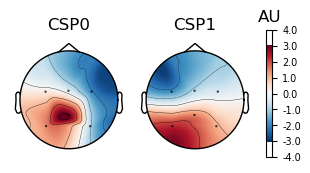

Accuracy: 0.8695652173913043
              precision    recall  f1-score   support

  none-right       0.88      0.94      0.91        31
       right       0.85      0.73      0.79        15

    accuracy                           0.87        46
   macro avg       0.86      0.83      0.85        46
weighted avg       0.87      0.87      0.87        46



In [179]:
csp_list = []
lr_list = []
acc_list = []
report_list = []

for i in range(2, len(epochs.ch_names) + 1):
    # -- |Features Extraction| --
    # Initilize CSP
    csp = CSP(n_components = i, norm_trace = False)

    # Fit CSP to data 
    csp.fit(X,Y)
    csp_list.append(csp)

    # Transform data into CSP space
    X_transformed = csp.transform(X)

    # -- |Classification| --
    # Split data into training and test sets
    X_train, X_test, Y_train, Y_test = train_test_split(X_transformed, Y, test_size = 0.2, random_state = 42, stratify=Y)

    # Classification 
    lr = Pipeline([('LR', LogisticRegression())])
    lr.fit(X_train, Y_train)
    lr_list.append(lr)

    y_pred = lr.predict(X_test)
    accuracy = accuracy_score(Y_test, y_pred)
    acc_list.append(accuracy)

    report = classification_report(Y_test, y_pred, target_names=['none-right', 'right'])  # adjust target names accordingly
    report_list.append(report)

# -- |Select CSP which gives maximum accuracy| --
ind = np.argmax(acc_list) 

# -- |Print Data Shape| --
print(f'Train set shape: {X_train.shape}')
print(f'Test set shape : {X_test.shape}')

# -- |Visualize CSP patterns| --
csp = csp_list[ind]
csp.plot_patterns(epochs.info);

# -- |Classification results| --
lr = lr_list[ind]
print(f"Accuracy: {acc_list[ind]}")
print(report_list[ind])

## Part 2: With artifact removal

### Artifact Correlations

C:\Users\AbsoluteZeno\AppData\Local\Temp\ipykernel_45656\2921723998.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['']+alpha)
C:\Users\AbsoluteZeno\AppData\Local\Temp\ipykernel_45656\2921723998.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(['']+alpha)


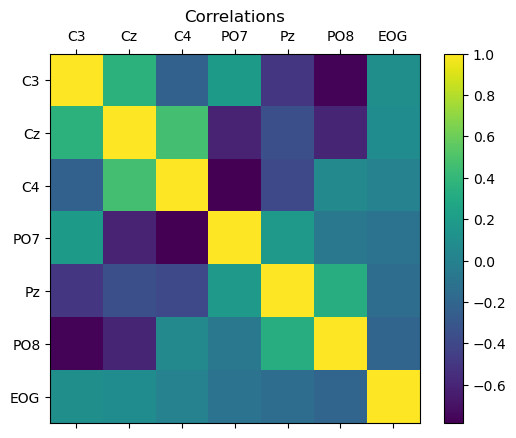

,C3,Cz,C4,PO7,Pz,PO8,EOG
C3,1.000000,0.359448,-0.230684,0.188224,-0.502217,-0.765335,0.103125
Cz,0.359448,1.000000,0.466434,-0.614615,-0.347447,-0.599955,0.084503
C4,-0.230684,0.466434,1.000000,-0.784746,-0.390691,0.052022,0.009289
PO7,0.188224,-0.614615,-0.784746,1.000000,0.172431,-0.073559,-0.106155
Pz,-0.502217,-0.347447,-0.390691,0.172431,1.000000,0.329080,-0.144033
PO8,-0.765335,-0.599955,0.052022,-0.073559,0.329080,1.000000,-0.204526
EOG,0.103125,0.084503,0.009289,-0.106155,-0.144033,-0.204526,1.000000


In [180]:
df = epochs.to_data_frame()
df_numerical = df[epochs.ch_names]

fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(df_numerical.corr(), interpolation='nearest')
fig.colorbar(cax)

alpha = epochs.ch_names
ax.set_xticklabels(['']+alpha)
ax.set_yticklabels(['']+alpha)
ax.set_title('Correlations')

plt.show()
df_numerical.corr()

C:\Users\AbsoluteZeno\AppData\Local\Temp\ipykernel_45656\3594465532.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['']+alpha)
C:\Users\AbsoluteZeno\AppData\Local\Temp\ipykernel_45656\3594465532.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(['']+alpha)


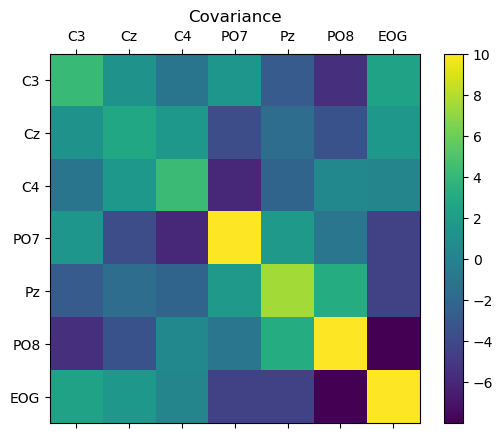

,C3,Cz,C4,PO7,Pz,PO8,EOG
C3,4.228476,1.222622,-0.979801,1.435458,-2.835413,-5.484208,2.378787
Cz,1.222622,2.736071,1.593611,-3.770427,-1.577921,-3.458221,1.567970
C4,-0.979801,1.593611,4.266343,-6.011466,-2.215615,0.374440,0.215239
PO7,1.435458,-3.770427,-6.011466,13.754572,1.755784,-0.950668,-4.416378
Pz,-2.835413,-1.577921,-2.215615,1.755784,7.538184,3.148509,-4.436045
PO8,-5.484208,-3.458221,0.374440,-0.950668,3.148509,12.143403,-7.995007
EOG,2.378787,1.567970,0.215239,-4.416378,-4.436045,-7.995007,125.835126


In [181]:
df = epochs.to_data_frame()
df_numerical = df[epochs.ch_names]

fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(df_numerical.cov(), interpolation='nearest',vmax=10)
fig.colorbar(cax)

alpha = epochs.ch_names
ax.set_xticklabels(['']+alpha)
ax.set_yticklabels(['']+alpha)
ax.set_title('Covariance')

plt.show()
df_numerical.cov()

In [182]:
df_numerical.corr()['EOG'][:-1].mul(df_numerical.std().iloc[:-1]/df_numerical.std().iloc[-1])

C3     0.018904
Cz     0.012461
C4     0.001710
PO7   -0.035097
Pz    -0.035253
PO8   -0.063536
dtype: float64

### 2.1 Visualize Original Data

#### Signal Average Over Epochs

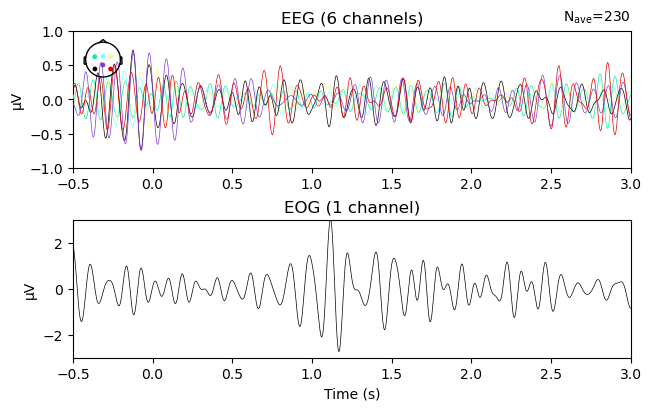

In [183]:
plot_kwargs = dict(picks="all", ylim=dict(eeg=(-1, 1), eog=(-3, 3)))

# plot the evoked for the EEG and the EOG sensors
fig = epochs.average("all").plot(**plot_kwargs)
fig.set_size_inches(6, 6)

#### Time Domain Plot

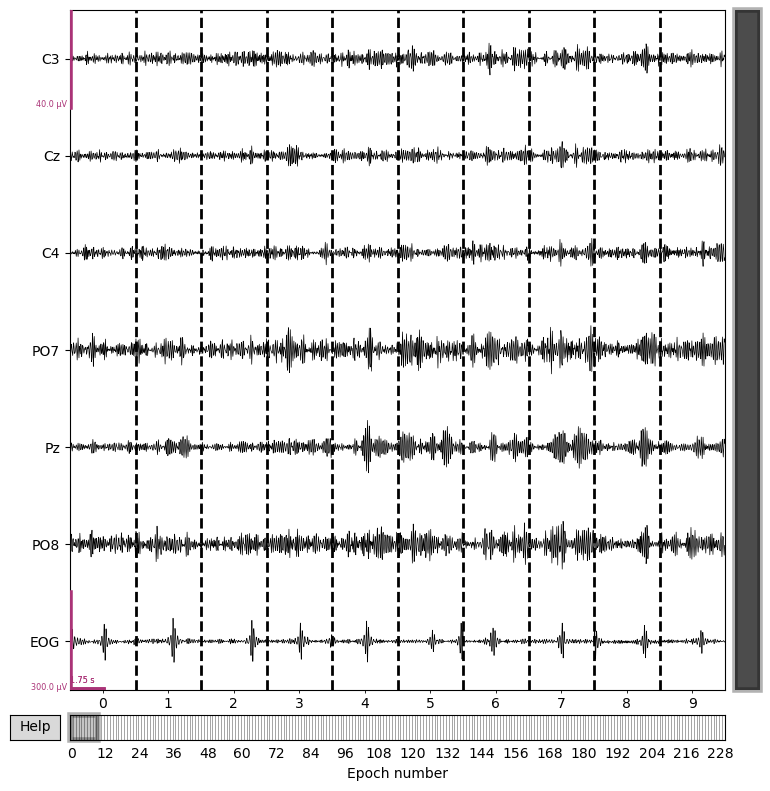

In [184]:
epochs.plot(picks='all', n_epochs=10);

### 2.2 Compute and Apply EOG Regression

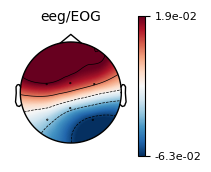

In [185]:
# Perform regression using the EOG sensor as independent variable and the EEG
# sensors as dependent variables.
model_plain = EOGRegression(picks="eeg", picks_artifact="eog").fit(epochs)

epochs_clean_plain = model_plain.apply(epochs)
# After regression, we should redo the baseline correction
epochs_clean_plain.apply_baseline()

fig = model_plain.plot()  # regression coefficients as topomap
fig.set_size_inches(3, 2)

In [186]:
model_plain.coef_

array([[ 0.01888168],
       [ 0.01241614],
       [ 0.00166773],
       [-0.03498411],
       [-0.03524363],
       [-0.06345381]])

#### Signal Average Over Epochs

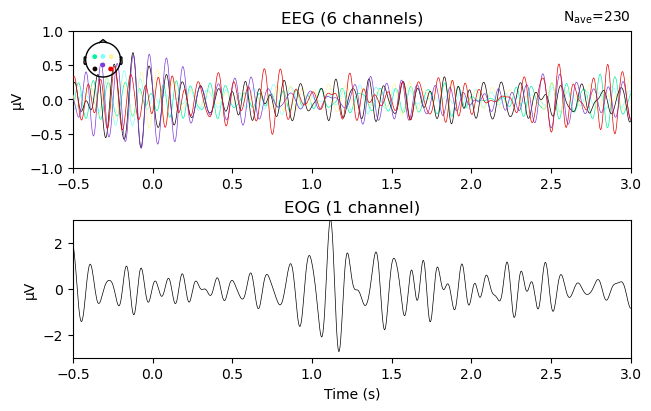

In [187]:
# Show the evoked potential computed on the corrected data
fig = epochs_clean_plain.average("all").plot(**plot_kwargs)
fig.set_size_inches(6, 6)

#### Time Domain Plot

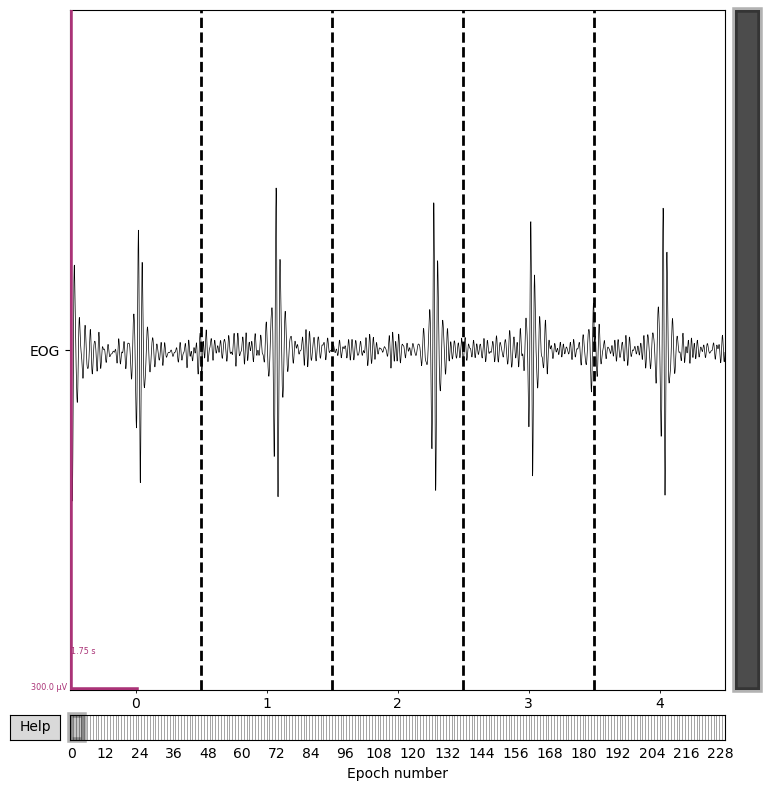

In [188]:
epochs_clean_plain.plot(picks='EOG', n_epochs=5);

### 2.3 Left vs. Right Classification

#### 2.3.1 SVM

Train set shape: (120, 7)
Test set shape : (30, 7)


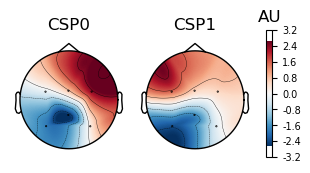

Accuracy: 0.7666666666666667
              precision    recall  f1-score   support

       right       0.83      0.67      0.74        15
        left       0.72      0.87      0.79        15

    accuracy                           0.77        30
   macro avg       0.78      0.77      0.76        30
weighted avg       0.78      0.77      0.76        30



In [189]:
# Get EEG data and events
X = epochs_clean_plain[['right','left']].get_data(copy=False)
Y = epochs_clean_plain[['right','left']].events[:, -1]

csp_list = []
svm_list = []
acc_list = []
report_list = []

for i in range(2, len(epochs.ch_names) + 1):
    # -- |Features Extraction| --
    # Initilize CSP
    csp = CSP(n_components = i, norm_trace = False)

    # Fit CSP to data 
    csp.fit(X,Y)
    csp_list.append(csp)

    # Transform data into CSP space
    X_transformed = csp.transform(X)

    # -- |Classification| --
    # Split data into training and test sets
    X_train, X_test, Y_train, Y_test = train_test_split(X_transformed, Y, test_size = 0.2, random_state = 42, stratify=Y)

    # Classification 
    svm = Pipeline([('SVM', SVC(kernel='linear'))])  
    svm.fit(X_train, Y_train)
    svm_list.append(svm)

    y_pred = svm.predict(X_test)
    accuracy = accuracy_score(Y_test, y_pred)
    acc_list.append(accuracy)

    report = classification_report(Y_test, y_pred, target_names=['right', 'left'])  # adjust target names accordingly
    report_list.append(report)

# -- |Select CSP which gives maximum accuracy| --
ind = np.argmax(acc_list) 

# -- |Print Data Shape| --
print(f'Train set shape: {X_train.shape}')
print(f'Test set shape : {X_test.shape}')

# -- |Visualize CSP patterns| --
csp = csp_list[ind]
csp.plot_patterns(epochs.info);

# -- |Classification results| --
svm = svm_list[ind]
print(f"Accuracy: {acc_list[ind]}")
print(report_list[ind])

#### 2.3.2 Logistic Regression

Train set shape: (120, 7)
Test set shape : (30, 7)


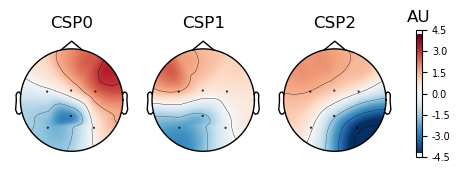

Accuracy: 0.7666666666666667
              precision    recall  f1-score   support

  none-right       0.83      0.67      0.74        15
       right       0.72      0.87      0.79        15

    accuracy                           0.77        30
   macro avg       0.78      0.77      0.76        30
weighted avg       0.78      0.77      0.76        30



In [190]:
csp_list = []
lr_list = []
acc_list = []
report_list = []

for i in range(2, len(epochs.ch_names) + 1):
    # -- |Features Extraction| --
    # Initilize CSP
    csp = CSP(n_components = i, norm_trace = False)

    # Fit CSP to data 
    csp.fit(X,Y)
    csp_list.append(csp)

    # Transform data into CSP space
    X_transformed = csp.transform(X)

    # -- |Classification| --
    # Split data into training and test sets
    X_train, X_test, Y_train, Y_test = train_test_split(X_transformed, Y, test_size = 0.2, random_state = 42, stratify=Y)

    # Classification 
    lr = Pipeline([('LR', LogisticRegression())])
    lr.fit(X_train, Y_train)
    lr_list.append(lr)

    y_pred = lr.predict(X_test)
    accuracy = accuracy_score(Y_test, y_pred)
    acc_list.append(accuracy)

    report = classification_report(Y_test, y_pred, target_names=['none-right', 'right'])  # adjust target names accordingly
    report_list.append(report)

# -- |Select CSP which gives maximum accuracy| --
ind = np.argmax(acc_list) 

# -- |Print Data Shape| --
print(f'Train set shape: {X_train.shape}')
print(f'Test set shape : {X_test.shape}')

# -- |Visualize CSP patterns| --
csp = csp_list[ind]
csp.plot_patterns(epochs.info);

# -- |Classification results| --
lr = lr_list[ind]
print(f"Accuracy: {acc_list[ind]}")
print(report_list[ind])

### 2.4 Left vs. Non-left Classification

#### 2.4.1 SVM

c:\Users\AbsoluteZeno\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\AbsoluteZeno\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\AbsoluteZeno\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train set shape: (184, 7)
Test set shape : (46, 7)


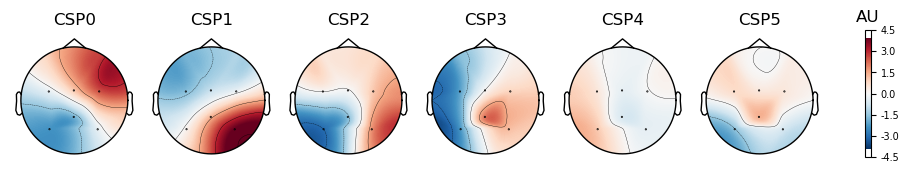

Accuracy: 0.7608695652173914
              precision    recall  f1-score   support

   none-left       0.78      0.90      0.84        31
        left       0.70      0.47      0.56        15

    accuracy                           0.76        46
   macro avg       0.74      0.68      0.70        46
weighted avg       0.75      0.76      0.75        46



In [257]:
epochs_clean_plain_l = epochs_clean_plain.copy()
epochs_clean_plain_l.events = mne.merge_events(epochs_clean_plain_l.events, [0, 1], 0, replace_events=True)
epochs_clean_plain_l.event_id = {'none-left': 0, 'left': 2}

# Get EEG data and events
X = epochs_clean_plain_l.get_data(copy=False)
Y = epochs_clean_plain_l.events[:, -1]

csp_list = []
svm_list = []
acc_list = []
report_list = []

for i in range(2, len(epochs.ch_names) + 1):
    # -- |Features Extraction| --
    # Initilize CSP
    csp = CSP(n_components = i, norm_trace = False)

    # Fit CSP to data 
    csp.fit(X,Y)
    csp_list.append(csp)

    # Transform data into CSP space
    X_transformed = csp.transform(X)

    # -- |Classification| --
    # Split data into training and test sets
    X_train, X_test, Y_train, Y_test = train_test_split(X_transformed, Y, test_size = 0.2, random_state = 42, stratify=Y)

    # Classification 
    svm = Pipeline([('SVM', SVC(kernel='linear'))])  
    svm.fit(X_train, Y_train)
    svm_list.append(svm)

    y_pred = svm.predict(X_test)
    accuracy = accuracy_score(Y_test, y_pred)
    acc_list.append(accuracy)

    report = classification_report(Y_test, y_pred, target_names=['none-left', 'left'])  # adjust target names accordingly
    report_list.append(report)

# -- |Select CSP which gives maximum accuracy| --
ind = np.argmax(acc_list) 

# -- |Print Data Shape| --
print(f'Train set shape: {X_train.shape}')
print(f'Test set shape : {X_test.shape}')

# -- |Visualize CSP patterns| --
csp = csp_list[ind]
csp.plot_patterns(epochs.info);

# -- |Classification results| --
svm = svm_list[ind]
print(f"Accuracy: {acc_list[ind]}")
print(report_list[ind])

#### 2.4.2 Logistic Regression

Train set shape: (184, 7)
Test set shape : (46, 7)


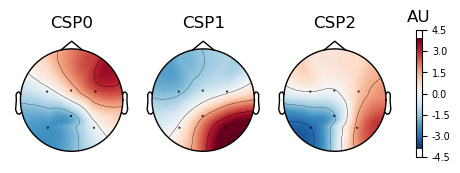

Accuracy: 0.7391304347826086
              precision    recall  f1-score   support

  none-right       0.74      0.94      0.83        31
       right       0.71      0.33      0.45        15

    accuracy                           0.74        46
   macro avg       0.73      0.63      0.64        46
weighted avg       0.73      0.74      0.71        46



In [258]:
csp_list = []
lr_list = []
acc_list = []
report_list = []

for i in range(2, len(epochs.ch_names) + 1):
    # -- |Features Extraction| --
    # Initilize CSP
    csp = CSP(n_components = i, norm_trace = False)

    # Fit CSP to data 
    csp.fit(X,Y)
    csp_list.append(csp)

    # Transform data into CSP space
    X_transformed = csp.transform(X)

    # -- |Classification| --
    # Split data into training and test sets
    X_train, X_test, Y_train, Y_test = train_test_split(X_transformed, Y, test_size = 0.2, random_state = 42, stratify=Y)

    # Classification 
    lr = Pipeline([('LR', LogisticRegression())])
    lr.fit(X_train, Y_train)
    lr_list.append(lr)

    y_pred = lr.predict(X_test)
    accuracy = accuracy_score(Y_test, y_pred)
    acc_list.append(accuracy)

    report = classification_report(Y_test, y_pred, target_names=['none-right', 'right'])  # adjust target names accordingly
    report_list.append(report)

# -- |Select CSP which gives maximum accuracy| --
ind = np.argmax(acc_list) 

# -- |Print Data Shape| --
print(f'Train set shape: {X_train.shape}')
print(f'Test set shape : {X_test.shape}')

# -- |Visualize CSP patterns| --
csp = csp_list[ind]
csp.plot_patterns(epochs.info);

# -- |Classification results| --
lr = lr_list[ind]
print(f"Accuracy: {acc_list[ind]}")
print(report_list[ind])

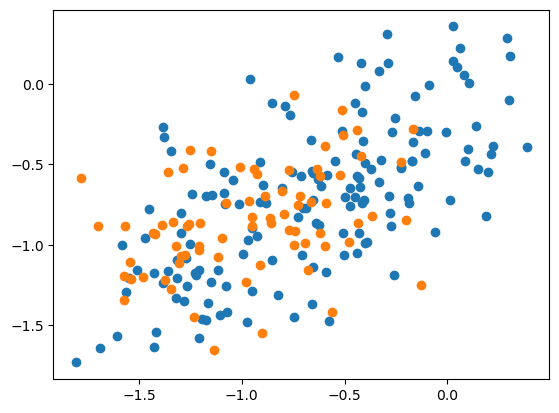

In [259]:
import matplotlib.pyplot as plt
X_transformed = csp.transform(X)
y_pred = lr.predict(X_transformed)
f0 = np.array([X_transformed[i] for i in range(Y.shape[0]) if Y[i] == 0 ])
f1 = np.array([X_transformed[i] for i in range(Y.shape[0]) if Y[i] == 2 ])

plt.plot(f0[:,0],f0[:,1],'o')
plt.plot(f1[:,0],f1[:,1],'o')
plt.show()

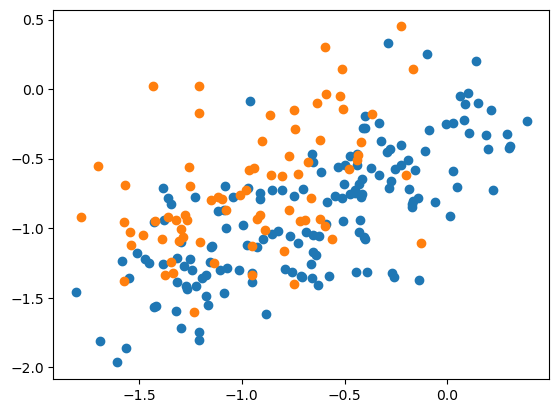

In [272]:
plt.plot(f0[:,0],f0[:,2],'o')
plt.plot(f1[:,0],f1[:,2],'o')
plt.show()

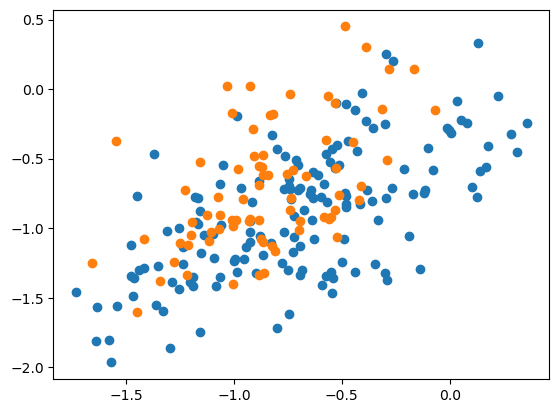

In [273]:
plt.plot(f0[:,1],f0[:,2],'o')
plt.plot(f1[:,1],f1[:,2],'o')
plt.show()

In [261]:
Y

array([2, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 2, 0, 2, 2, 2, 0, 2, 2, 2, 0,
       0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0,
       2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 2, 2, 2, 0, 0, 2, 0, 0, 0, 0,
       2, 2, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 2, 0,
       2, 0, 2, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 2, 2, 2, 0, 2, 2, 0, 0,
       2, 0, 0, 2, 0, 2, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 2,
       0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 2, 0, 0, 2, 0, 2, 2, 0,
       0, 2, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 2, 2, 0, 2, 2, 2, 0, 0, 0,
       2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 2, 2, 2, 2, 0, 2, 0,
       2, 0, 0, 0, 0, 2, 0, 2, 0, 2, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 2, 2, 0, 0, 0])

In [260]:
y_pred

array([0, 2, 2, 2, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 2, 0, 2, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0,
       0, 0, 2, 0, 0, 0, 2, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 2, 2, 0, 0, 0, 0, 0, 0,
       2, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2,
       0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0,
       0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 2, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 2, 0, 2, 2,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 2, 0, 2, 0, 0, 0, 0, 0, 0])

In [270]:
ypos = np.array([(y_pred[i],Y[i]) for i in range(Y.shape[0]) if Y[i] == 2 ])
len(ypos)

75

In [271]:
ytruepos = np.array([(y_pred[i],Y[i]) for i in range(Y.shape[0]) if Y[i] == 2 and y_pred[i] == 2])
len(ytruepos)

31

In [262]:
len(Y)

230

In [265]:
np.sum(Y==y_pred)

173

### 2.5 Right vs. Non-Right Classification

#### 2.5.1 SVM

Train set shape: (184, 7)
Test set shape : (46, 7)


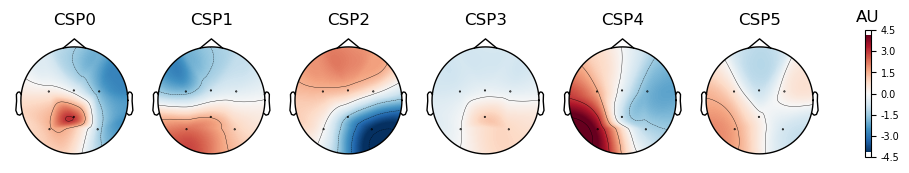

Accuracy: 0.8913043478260869
              precision    recall  f1-score   support

  none-right       0.93      0.90      0.92        31
       right       0.81      0.87      0.84        15

    accuracy                           0.89        46
   macro avg       0.87      0.88      0.88        46
weighted avg       0.89      0.89      0.89        46



In [248]:
epochs_clean_plain_r = epochs_clean_plain.copy()
epochs_clean_plain_r.events = mne.merge_events(epochs_clean_plain_r.events, [0, 2], 0, replace_events=True)
epochs_clean_plain_r.event_id = {'none-right': 0, 'right': 1}

# Get EEG data and events
X = epochs_clean_plain_r.get_data(copy=False)
Y = epochs_clean_plain_r.events[:, -1]

csp_list = []
svm_list = []
acc_list = []
report_list = []

for i in range(2, len(epochs.ch_names) + 1):
    # -- |Features Extraction| --
    # Initilize CSP
    csp = CSP(n_components = i, norm_trace = False)

    # Fit CSP to data 
    csp.fit(X,Y)
    csp_list.append(csp)

    # Transform data into CSP space
    X_transformed = csp.transform(X)

    # -- |Classification| --
    # Split data into training and test sets
    X_train, X_test, Y_train, Y_test = train_test_split(X_transformed, Y, test_size = 0.2, random_state = 42, stratify=Y)

    # Classification 
    svm = Pipeline([('SVM', SVC(kernel='linear'))])  
    svm.fit(X_train, Y_train)
    svm_list.append(svm)

    y_pred = svm.predict(X_test)
    accuracy = accuracy_score(Y_test, y_pred)
    acc_list.append(accuracy)

    report = classification_report(Y_test, y_pred, target_names=['none-right', 'right'])  # adjust target names accordingly
    report_list.append(report)

# -- |Select CSP which gives maximum accuracy| --
ind = np.argmax(acc_list) 

# -- |Print Data Shape| --
print(f'Train set shape: {X_train.shape}')
print(f'Test set shape : {X_test.shape}')

# -- |Visualize CSP patterns| --
csp = csp_list[ind]
csp.plot_patterns(epochs.info);

# -- |Classification results| --
svm = svm_list[ind]
print(f"Accuracy: {acc_list[ind]}")
print(report_list[ind])

#### 2.5.2 Logistic Regression

Train set shape: (184, 7)
Test set shape : (46, 7)


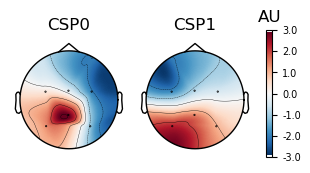

Accuracy: 0.8695652173913043
              precision    recall  f1-score   support

  none-right       0.88      0.94      0.91        31
       right       0.85      0.73      0.79        15

    accuracy                           0.87        46
   macro avg       0.86      0.83      0.85        46
weighted avg       0.87      0.87      0.87        46



In [249]:
csp_list = []
lr_list = []
acc_list = []
report_list = []

for i in range(2, len(epochs.ch_names) + 1):
    # -- |Features Extraction| --
    # Initilize CSP
    csp = CSP(n_components = i, norm_trace = False)

    # Fit CSP to data 
    csp.fit(X,Y)
    csp_list.append(csp)

    # Transform data into CSP space
    X_transformed = csp.transform(X)

    # -- |Classification| --
    # Split data into training and test sets
    X_train, X_test, Y_train, Y_test = train_test_split(X_transformed, Y, test_size = 0.2, random_state = 42, stratify=Y)

    # Classification 
    lr = Pipeline([('LR', LogisticRegression())])
    lr.fit(X_train, Y_train)
    lr_list.append(lr)

    y_pred = lr.predict(X_test)
    accuracy = accuracy_score(Y_test, y_pred)
    acc_list.append(accuracy)

    report = classification_report(Y_test, y_pred, target_names=['none-right', 'right'])  # adjust target names accordingly
    report_list.append(report)

# -- |Select CSP which gives maximum accuracy| --
ind = np.argmax(acc_list) 

# -- |Print Data Shape| --
print(f'Train set shape: {X_train.shape}')
print(f'Test set shape : {X_test.shape}')

# -- |Visualize CSP patterns| --
csp = csp_list[ind]
csp.plot_patterns(epochs.info);

# -- |Classification results| --
lr = lr_list[ind]
print(f"Accuracy: {acc_list[ind]}")
print(report_list[ind])

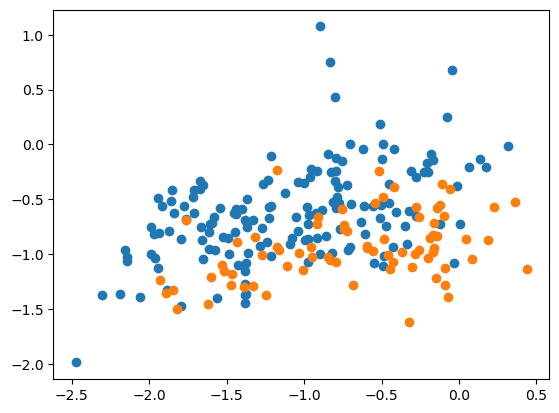

In [250]:
import matplotlib.pyplot as plt
X_transformed = csp.transform(X)
f0 = np.array([X_transformed[i] for i in range(Y.shape[0]) if Y[i] == 0 ])
f1 = np.array([X_transformed[i] for i in range(Y.shape[0]) if Y[i] == 1 ])

plt.plot(f0[:,0],f0[:,1],'o')
plt.plot(f1[:,0],f1[:,1],'o')
plt.show()